In [1]:
#
# to run this you need groundingdino and sam
# install with:
#  pip install git+https://github.com/facebookresearch/segment-anything.git
#  pip install groundingdino-py

%pylab inline
from PIL import Image
from lang_sam import LangSAM

import numpy as np
import cv2



# Bunch of assumptions
FOCAL_LENGTH = 910
H = 1080
W = 1920
intrinics_K = np.array([[FOCAL_LENGTH,  0.0, float(W)/2],
                      [0.0, FOCAL_LENGTH, float(H)/2],
                      [0.0,  0.0, 1.0]])
distortion_D = None
CAMERA_HEIGHT = 1.5
MAX_DEPTH = 300


def normalize(img_pts, intrinsics):
  # normalizes image coordinates
  # accepts single pt or array of pts
  intrinsics_inv = np.linalg.inv(intrinsics)
  img_pts = np.array(img_pts)
  input_shape = img_pts.shape
  img_pts = np.atleast_2d(img_pts)
  img_pts = np.hstack((img_pts, np.ones((img_pts.shape[0], 1))))
  img_pts_normalized = img_pts.dot(intrinsics_inv.T)
  img_pts_normalized[(img_pts < 0).any(axis=1)] = np.nan
  return img_pts_normalized[:, :2].reshape(input_shape)

def normalize_with_distortion(points, K, D):
  if D is not None:
    shape = points.shape
    points = np.atleast_2d(points)
    return np.squeeze(cv2.fisheye.undistortPoints(points[:,None].astype(np.float32), K, D)).reshape(shape)
  else:
    return normalize(points, K)


def get_water_depth():
  # TODO should depend on camera angle to water
  uv = -np.ones(list((H, W)) + [2,], dtype=int)
  uv[:,:,0] = np.tile(np.arange(W)[None, :], (H, 1))
  uv[:,:,1] = np.tile(np.arange(H)[:, None], (1, W))
  uv_norm = normalize_with_distortion(uv.reshape((-1,2)), intrinics_K, distortion_D)
  uvw_norm = np.hstack([uv_norm, np.ones((H*W, 1))])
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:,1:2]
  depth = uvw_norm[:, 2]
  depth[depth < 0] = MAX_DEPTH
  depth = np.clip(depth, 0, MAX_DEPTH)
  return depth.reshape((H, W))

def get_closest_object(mask):
  depth_map = get_water_depth()

  nonwater_depth = MAX_DEPTH * np.ones_like(depth_map)
  nonwater_depth[~mask] = depth_map[~mask]
  min_nonwater_depth = np.nanmin(nonwater_depth, axis=0)
  return min_nonwater_depth

model = LangSAM()


def get_water_mask(image_filename):
  image_pil = Image.open(image_filename).convert("RGB")
  text_prompt = "water"
  masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)
  assert len(masks) == 1
  water_mask = masks[0]
  # bottom not water for some reason
  water_mask[-50:] = 1
  figure()
  imshow(water_mask)
  figure()
  imshow(image_pil)
  return water_mask

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/batman/seasat/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/batman/seasat/.venv/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/batman/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [2]:
def display_example(name):
  water_mask = get_water_mask(name)
  closest_object_dist = get_closest_object(water_mask)
  figure()
  title("Closest object distance")
  plot(closest_object_dist)
  ylim(0, 100)
  ylabel("Distance (m)")
  xlabel("Pixels")

/home/batman/seasat/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/batman/seasat/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/batman/seasat/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/tmp/ipykernel_233171/32606846.py:56: RuntimeWarning: divide by zero encountered in divide
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:

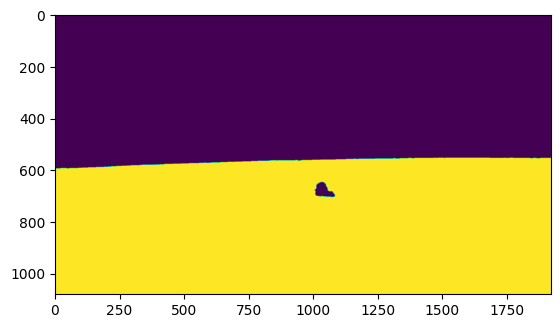

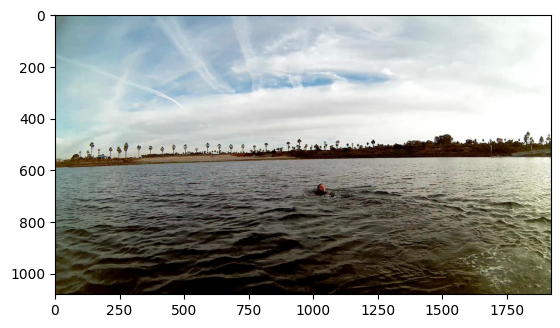

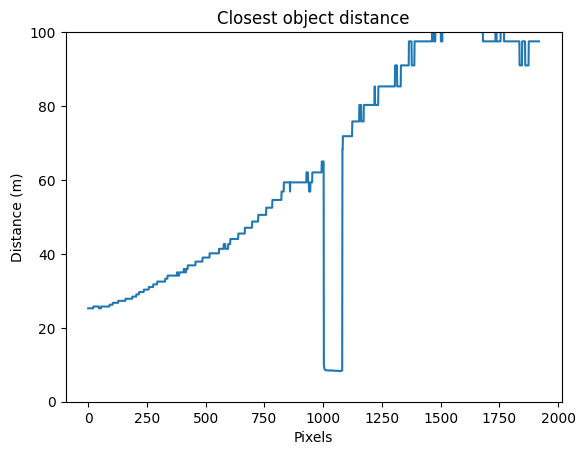

In [3]:
display_example("swimmer.jpg")

/tmp/ipykernel_233171/32606846.py:56: RuntimeWarning: divide by zero encountered in divide
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:,1:2]
/tmp/ipykernel_233171/32606846.py:56: RuntimeWarning: invalid value encountered in divide
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:,1:2]


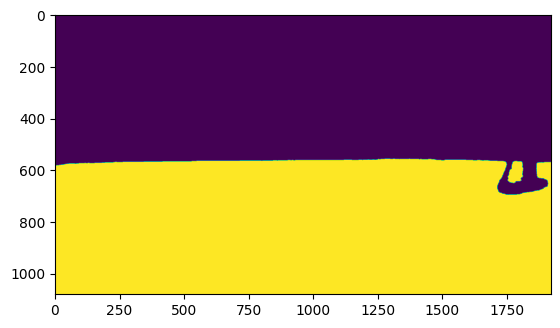

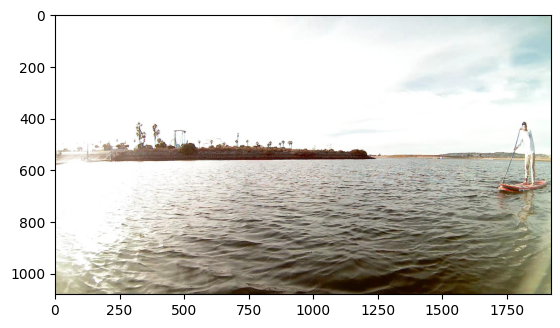

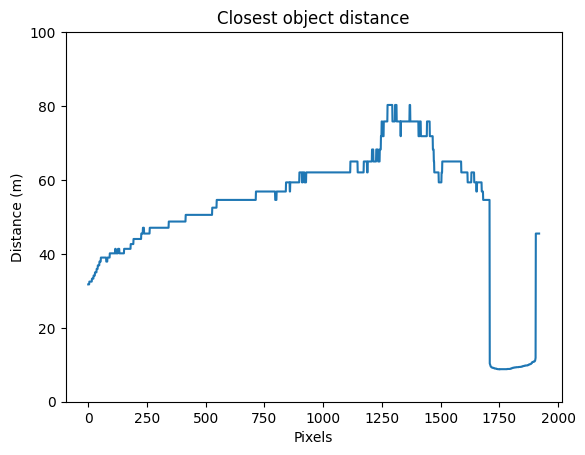

In [4]:
display_example("supman.jpg")

/tmp/ipykernel_233171/32606846.py:56: RuntimeWarning: divide by zero encountered in divide
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:,1:2]
/tmp/ipykernel_233171/32606846.py:56: RuntimeWarning: invalid value encountered in divide
  uvw_norm = CAMERA_HEIGHT * uvw_norm / uvw_norm[:,1:2]


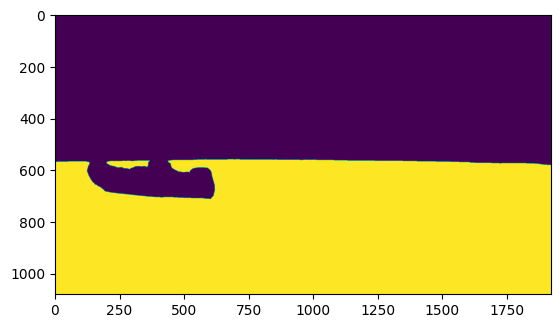

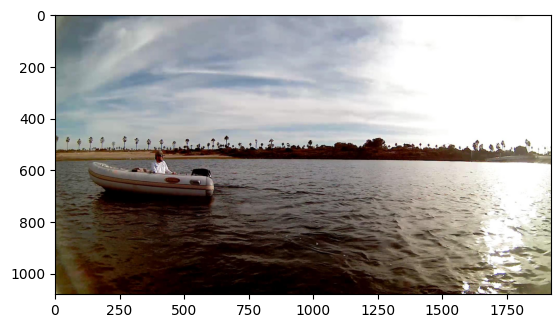

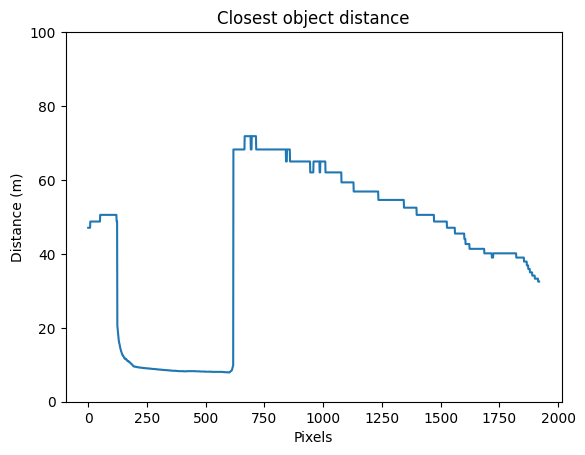

In [5]:
display_example("boat.jpg")